## David Liu
## BAN 676

## QUESTION 1:

#### Build a CNN Classification Model to classify species from the Orchid Flowers dataset (Use train and validation data for respective purpose, no testing needed)

#### (1) Model 1: from scratch using CNN layers

In [120]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image

print(tf.__version__)

2.3.0


## Preliminary Steps
Checking to see how many images are in the entire orchid data directory

In [121]:
orchid_directory = "Orchid Flowers Dataset-v1.1/Orchid_Images"

file_names = os.listdir(orchid_directory)
print(len(file_names), "images")

7160 images


Putting together a dataframe that shows the image file names and their associated labels. This dataframe will be used later to build an image dataset with associated labels.

In [122]:
img_label = pd.read_csv("Orchid Flowers Dataset-v1.1/Species_Classifier/ClassLabels.txt", header=None)
img_label.columns = ["Images","Labels"]
img_label["Labels"] = img_label["Labels"].astype(str)
img_label

,Images,Labels
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
...,...,...
7151,7152.jpeg,63
7152,7153.jpeg,63
7153,7154.jpeg,63
7154,7155.jpg,63


Identifying all image files' formats in the image folder. The tensorflow functions, flow_from_dataframe() and ImageDataGenerator(), which will be used later to create an image dataset, only accepts jpeg, png, bmp, and gif image formats.

In [123]:
file_names_df = pd.DataFrame(file_names)
file_names_df[0] = file_names_df[0].str.extract("[0-9]+.(.*)")
file_names_df_dummies = pd.get_dummies(file_names_df[0])
file_names_df_dummies.sum()

jfif       4
jpeg      34
jpg     7122
dtype: int64

Shown above, there are 4 jfif images, which not an acceptable image format. These images will be converted to jpeg.

In [124]:
deviant_files = []

for each in file_names:
    if each.endswith(".jfif") == True:
        deviant_files.append(each)

print(deviant_files)
  

['7067.jfif', '7068.jfif', '7069.jfif', '7071.jfif']


The 4 jfif files - '7067.jfif', '7068.jfif', '7069.jfif', and '7071.jfif' - are converted to jpg, and resaved into the image folder.

In [125]:
for each in deviant_files:
    im = Image.open(orchid_directory + "/" + each)
    im.save(orchid_directory + "/" + each.split(".")[0] + ".jpg")

The file names with the .jfif format extension in the img_label dataframe will be converted to the .jpg format extension. The strings under the "Images" column in the img_label dataframe will be used as directory names that points to an image file in the image folder. Therefore, the strings must match the image filenames in the image folder directory.  

In [126]:
for index in range(len(img_label)):
    if img_label.iloc[index,0] in deviant_files:
        img_label.iloc[index,0] = img_label.iloc[index,0].split(".")[0] + ".jpg"

Identifying all image formats in the orchid image folder again.

In [127]:
formats = img_label["Images"].str.extract("[0-9]+.(.*)")

formats_dummies = pd.get_dummies(formats[0])
formats_dummies.sum()


jpeg      34
jpg     7122
dtype: int64

Few lines from the img_label dataframe

In [128]:
img_label.head(20)

,Images,Labels
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,1
4,5.jpg,1
5,6.jpg,1
6,7.jpg,1
7,8.jpg,1
8,9.jpg,1
9,10.jpg,1


## Split Training/Validation Data

Extracting the data again, and splitting them into training and validation data. Extracted images are resized to 500 x 500 in order to accommodate the majority of image sizes in the data directory. The number of classes shown in the outputs below are inferred by the function. 

In [129]:
image_data=ImageDataGenerator(rescale=1./255.,validation_split=0.3)

In [130]:
orchid_img_train = image_data.flow_from_dataframe(
    dataframe=img_label,
    directory = "Orchid Flowers Dataset-v1.1/Orchid_Images/",
    subset = "training",
    x_col = "Images",
    y_col = "Labels",
    batch_size = 32,
    seed = 2,
    shuffle = False,
    class_mode = "categorical",
    target_size = (300,300),
)

Found 5010 validated image filenames belonging to 156 classes.


In [131]:
orchid_img_val = image_data.flow_from_dataframe(
    dataframe=img_label,
    directory = "Orchid Flowers Dataset-v1.1/Orchid_Images/",
    subset = "validation",
    x_col = "Images",
    y_col = "Labels",
    batch_size = 32,
    seed = 2,
    shuffle = False,
    class_mode = "categorical",
    target_size = (300,300),
)

Found 2146 validated image filenames belonging to 156 classes.


Displaying some images from the training and validation datasets. The purpose of this is to get an idea of what the images look like, and to determine whether there might be possible issues as a result of the images being resized.

Training Data

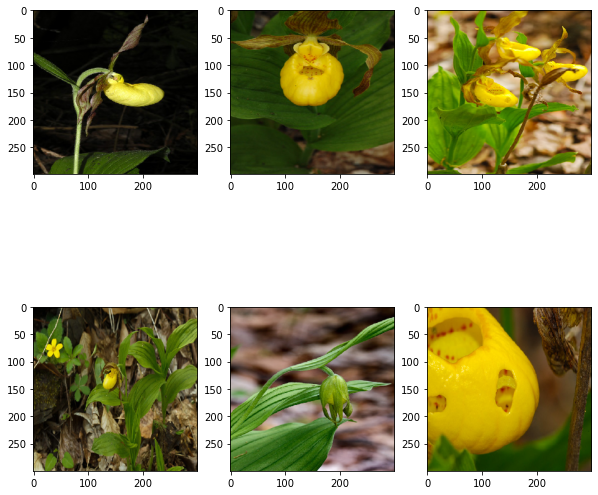

In [132]:
x,y = orchid_img_train.next()

plt.figure(figsize=(10,10))

for each in range(6):
    plt.subplot(2,3, each+1)
    image = x[each]
    plt.imshow(image)

Validation Data

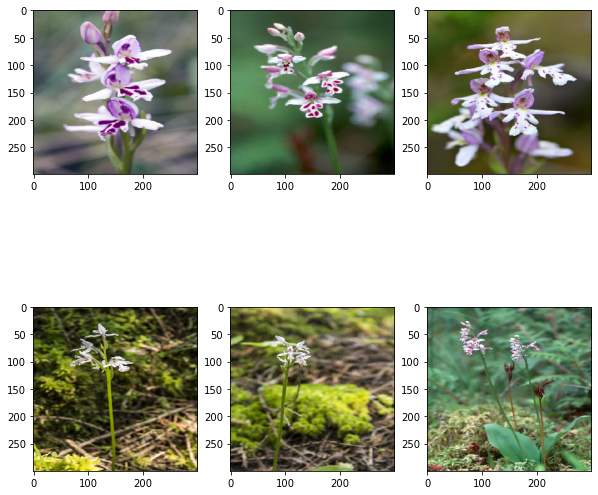

In [133]:
#help(orchid_img_val)
x,y = orchid_img_val.next()

plt.figure(figsize=(10,10))

for each in range(6):
    plt.subplot(2,3, each+1)
    image = x[each]
    plt.imshow(image)

## Building the Model

Creating the CNN model

In [134]:
orchid_model = keras.Sequential()
orchid_model.add(keras.layers.Conv2D(64, (3, 3), padding='same', input_shape=(300,300,3)))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.Conv2D(32, (3, 3)))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
orchid_model.add(keras.layers.Dropout(0.25))

orchid_model.add(keras.layers.Conv2D(42, (3, 3), padding='same'))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.Conv2D(32, (3, 3)))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
orchid_model.add(keras.layers.Dropout(0.25))

orchid_model.add(keras.layers.Conv2D(32, (3, 3), padding='same'))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.Conv2D(32, (3, 3)))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
orchid_model.add(keras.layers.Dropout(0.25))

orchid_model.add(keras.layers.Conv2D(32, (3, 3), padding='same'))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.Conv2D(32, (3, 3)))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
orchid_model.add(keras.layers.Dropout(0.25))

orchid_model.add(keras.layers.Flatten())
orchid_model.add(keras.layers.Dense(512))
orchid_model.add(keras.layers.Activation('relu'))
orchid_model.add(keras.layers.Dropout(0.5))

orchid_model.add(keras.layers.Dense(156, activation='softmax'))
orchid_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Below codes reset the model, if needed

In [139]:
orchid_model.reset_states()
tf.keras.backend.clear_session()

In [135]:
orchid_model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [137]:
train_step = orchid_img_train.n//orchid_img_train.batch_size
val_step = orchid_img_val.n//orchid_img_val.batch_size

history = orchid_model.fit_generator(generator = orchid_img_train, 
                                     steps_per_epoch = train_step,
                                     validation_data = orchid_img_val, 
                                     validation_steps = val_step,
                                     epochs=3)

Epoch 1/5
156/156 [==============================] - 1108s 7s/step - loss: 4.9706 - accuracy: 0.0165 - val_loss: 5.5829 - val_accuracy: 0.0676
Epoch 2/5
156/156 [==============================] - 1115s 7s/step - loss: 4.5633 - accuracy: 0.0319 - val_loss: 6.3423 - val_accuracy: 0.0676
Epoch 3/5
156/156 [==============================] - 1103s 7s/step - loss: 4.4808 - accuracy: 0.0396 - val_loss: 6.3730 - val_accuracy: 0.0676
Epoch 4/5
156/156 [==============================] - 1102s 7s/step - loss: 4.4501 - accuracy: 0.0360 - val_loss: 6.5078 - val_accuracy: 0.0676
Epoch 5/5
 26/156 [====>.........................] - ETA: 13:57 - loss: 4.5753 - accuracy: 0.0012

KeyboardInterrupt: 

In [159]:
orchid_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 300, 300, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 298, 298, 32)      18464     
_________________________________________________________________
activation_1 (Activation)    (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 149, 149, 42)      1

Calculating the naive model accuracy. This is a categorical problem. In order to find a decent baseline accuracy for which the CNN model must exceed, we will find the proportion of the category with the highest rate of occurrence. The highest proportion will be used as the baseline accuracy.  

In [156]:
total = img_label["Images"].count()

max_prob_category = img_label.groupby(["Labels"]).agg("count").reset_index()

max_prob_category = max(max_prob_category["Images"])

baseline_acc = max_prob_category/total

baseline_acc

0.052124091671324764

Plotting the training and validation prediction accuracy over epochs

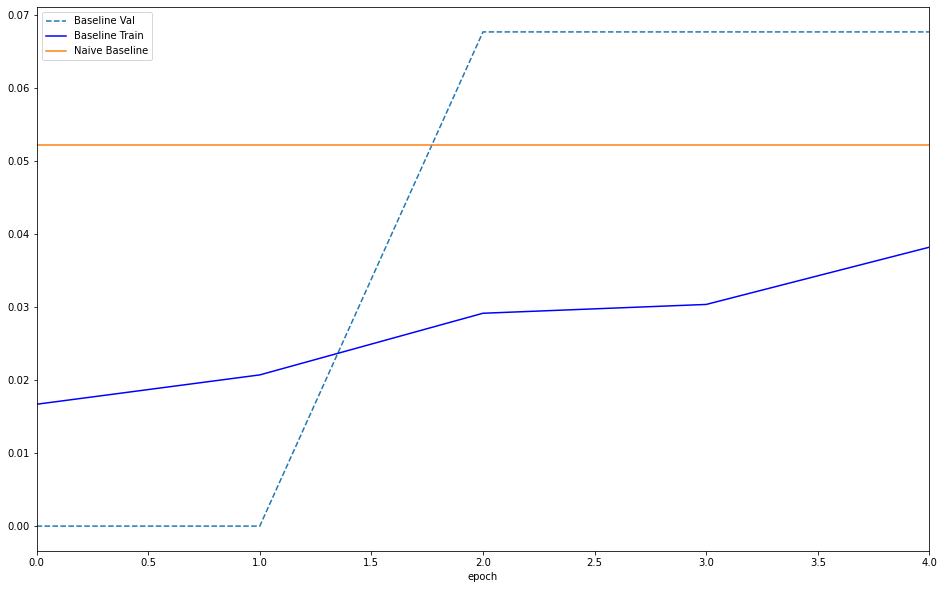

In [158]:
plt.figure(figsize=(16,10))
plt.plot(history.epoch, history.history['val_accuracy'],'--', label='Baseline Val')
plt.plot(history.epoch, history.history['accuracy'], color='blue', label='Baseline Train')
plt.plot([0,5], [baseline_acc, baseline_acc], label = 'Naive Baseline')
plt.xlabel("epoch")
plt.xlim([0,max(history.epoch)])
#plt.ylim([0,1])
plt.legend()
plt.show()

## QUESTION 2:

#### Build a CNN Classification Model to classify species from the Orchid Flowers dataset (Use train and validation data for respective purpose, no testing needed)

#### (1) Model 2: Use Transfer learning or fine tuning

## Building the Transfer Learning Model

This transfer learning model will be built with Resnet50.

In [200]:
t_model.reset_states()
tf.keras.backend.clear_session()

In [201]:
orchid_input = tf.keras.Input(shape=(300,300,3))

t_model = tf.keras.applications.VGG16(include_top = False, input_shape=(300,300,3))

for layer in t_model.layers:
    layer.trainable = False

flat_layer = tf.keras.layers.Flatten()(t_model.layers[-1].output)
dense_layer = tf.keras.layers.Dense(512, activation="relu")(flat_layer)
output_layer = tf.keras.layers.Dense(156, activation="softmax")(dense_layer)

t_model = tf.keras.Model(inputs=t_model.inputs, outputs=output_layer)

t_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)      

In [202]:
t_model.compile(optimizer=keras.optimizers.SGD(lr=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_step = orchid_img_train.n//orchid_img_train.batch_size
val_step = orchid_img_val.n//orchid_img_val.batch_size

t_history = t_model.fit_generator(generator = orchid_img_train, 
                                steps_per_epoch = train_step,
                                validation_data = orchid_img_val, 
                                validation_steps = val_step,
                                epochs=10)

Epoch 1/10
 78/156 [==============>...............] - ETA: 6:10 - loss: 5.7253 - accuracy: 0.0088

In [ ]:
#label = tf.keras.applications.vgg16.decode_predictions(t_model)
#label